# Compiling Unitaries: MPO-Based Circuit Optimization
## From Time Evolution Operators to Quantum Circuits

In Notebooks 01–03 we compiled **states** (MPS → circuit). Now we tackle a different problem: compiling **unitaries** — finding a short-depth circuit that approximates a given unitary operator $U$.

The approach:
1. Represent the target unitary as a **Matrix Product Operator** (MPO)
2. Create a parameterized ansatz circuit (brick-wall layout)
3. Optimize the ansatz gates to minimize the **Hilbert-Schmidt Test** (HST) cost

$$C_{\mathrm{HST}} = 1 - \frac{|\mathrm{Tr}(U^\dagger V)|^2}{4^n}$$

where $U$ is the target and $V$ is the ansatz circuit. $C_{\mathrm{HST}} = 0$ means perfect compilation.

In this notebook you will:
1. Build a target unitary from Trotter time evolution
2. Optimize brick-wall circuits at increasing depths
3. Study convergence and final cost vs depth
4. Compare Trotter error bounds across orders
5. See how evolution time affects compilation difficulty

## Setup

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using TenSynth
using TenSynth.Core
using TenSynth.MPO
using TenSynth.Hamiltonians

# Qualified imports to avoid conflicts with MPS module
using TenSynth.MPO: bond_dimensions as mpo_bond_dimensions

using LinearAlgebra
using Random
using Plots
gr()

Random.seed!(42)
println("TenSynth loaded successfully.")

  Activating project at `~/Documents/Programming/PhD/ClaudeCodeExperiments/TenSynth_Master/TenSynthRepo/TenSynth`


TenSynth loaded successfully.


## 1. Building a Target Unitary

We'll compile the time-evolution operator $U = e^{-iHt}$ for the TFIM on a small chain. The `tfim_trotter_circuit()` function creates a Trotter decomposition as explicit unitary gates, which we then convert to an MPO.

In [2]:
n_qubits = 4
dt = 0.5   # evolution time
h_field = 1.0  # transverse field (critical point)

# Create a Trotter circuit for the TFIM
trotter_circ = tfim_trotter_circuit(n_qubits, dt, h_field;
    order=:second, n_steps=10)

println("Trotter circuit: $(length(trotter_circ.layers)) layers, $(n_qubits) qubits")

# Convert to MPO
target = circuit_to_mpo(trotter_circ)
println("Target MPO bond dimensions: $(mpo_bond_dimensions(target))")

# How far is it from the identity?
id_mpo = identity_mpo(n_qubits)
println("HST cost vs identity: $(round(hst_cost(target, id_mpo), digits=6))")

Trotter circuit: 40 layers, 4 qubits
Target MPO bond dimensions: [4, 16, 4]
HST cost vs identity: 0.86483


## 2. Optimizing at Increasing Depths

Instead of random initialization, we use **Trotter circuits with fewer steps** as the starting ansatz. Since the target is a 10-step second-order Trotter circuit, a 1-step or 2-step circuit already provides a coarse approximation. The optimizer then refines the gates to compensate for the Trotter error, giving a physically-motivated warm start that avoids local minima.

In [3]:
n_steps_list = [1, 2, 3, 5]
step_results = Dict{Int, OptimizationResult}()

for ns in n_steps_list
    ansatz = tfim_trotter_circuit(n_qubits, dt, h_field;
        order=:second, n_steps=ns)
    n_layers = length(ansatz.layers)
    config = OptimizerConfig(
        n_sweeps=20,
        n_layer_sweeps=2,
        verbose=false
    )
    result = optimize!(target, ansatz, config)
    step_results[ns] = result
    println("n_steps=$ns ($n_layers layers):  initial=$(round(result.initial_cost, digits=6)),  ",
            "final=$(round(result.final_cost, sigdigits=4))")
end

n_steps=1 (4 layers):  initial=0.00601,  final=1.986e-6
n_steps=2 (8 layers):  initial=0.000264,  final=1.976e-7
n_steps=3 (12 layers):  initial=4.5e-5,  final=8.436e-9
n_steps=5 (20 layers):  initial=4.0e-6,  final=6.107e-10


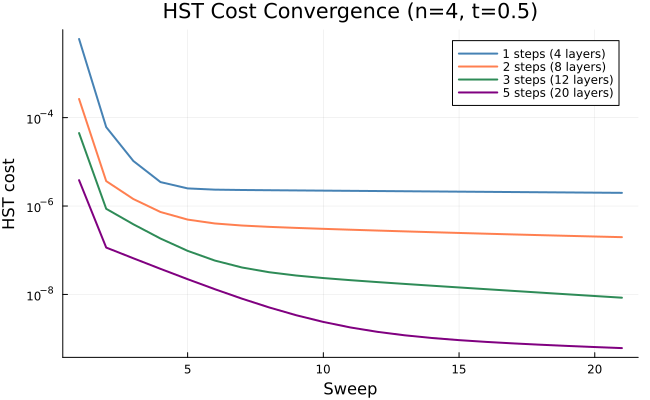

In [4]:
p = plot(title="HST Cost Convergence (n=$n_qubits, t=$dt)",
         xlabel="Sweep", ylabel="HST cost",
         yscale=:log10, legend=:topright, size=(650, 400))

colors = [:steelblue, :coral, :seagreen, :purple]
for (i, ns) in enumerate(n_steps_list)
    history = step_results[ns].cost_history
    n_layers = 4 * ns
    plot!(p, 1:length(history), history,
          label="$ns steps ($n_layers layers)", linewidth=2, color=colors[i])
end

p

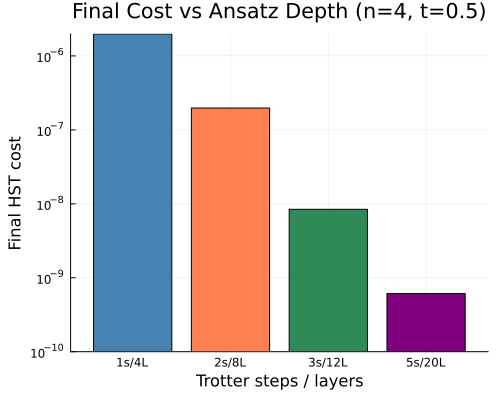

In [5]:
final_costs = [step_results[ns].final_cost for ns in n_steps_list]
labels = ["$(ns)s/$(4ns)L" for ns in n_steps_list]

p = bar(labels, final_costs,
    ylabel="Final HST cost", xlabel="Trotter steps / layers",
    title="Final Cost vs Ansatz Depth (n=$n_qubits, t=$dt)",
    yscale=:log10, legend=false,
    color=[:steelblue, :coral, :seagreen, :purple],
    size=(500, 400))

p

By initializing with Trotter circuits, the optimizer starts from a physically meaningful point rather than a random one. The initial cost reflects the **Trotter error** between the coarse ansatz and the fine target, and decreases with more steps. After optimization, the final cost drops further as the optimizer refines each gate. More layers (more Trotter steps) give the optimizer more parameters to work with, leading to monotonically lower final costs — unlike random initialization, which often gets trapped in local minima.

## 3. Trotter Error Bounds

The Trotter decomposition itself introduces error. Higher-order formulas converge faster with more steps. Let's compare 1st, 2nd, and 4th order.

In [6]:
H = TFIMHamiltonian(2; J=1.0, h=1.0)
t_total = 1.0
steps_range = [2, 4, 8, 16, 32, 64]
orders = [:first, :second, :fourth]

trotter_bounds = Dict{Symbol, Vector{Float64}}()
for ord in orders
    bounds = Float64[]
    for ns in steps_range
        b = trotter_error_bound(H, t_total; order=ord, n_steps=ns)
        push!(bounds, b)
    end
    trotter_bounds[ord] = bounds
    println("$ord:  steps=2 → $(round(bounds[1], sigdigits=3)),  ",
            "steps=64 → $(round(bounds[end], sigdigits=3))")
end

first:  steps=2 → 4.0,  steps=64 → 0.125
second:  steps=2 → 5.66,  steps=64 → 0.00552
fourth:  steps=2 → 11.3,  steps=64 → 1.08e-5


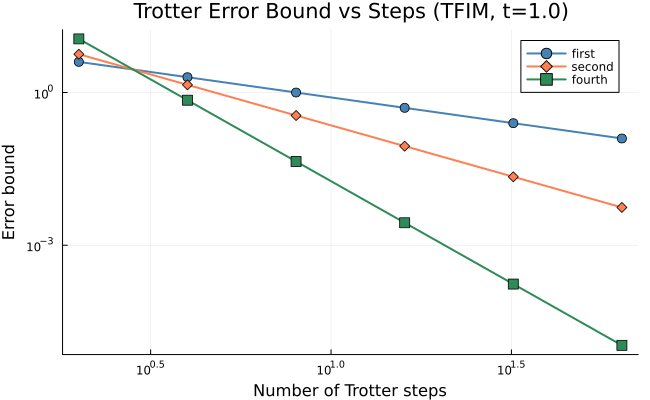

In [7]:
p = plot(title="Trotter Error Bound vs Steps (TFIM, t=$t_total)",
         xlabel="Number of Trotter steps", ylabel="Error bound",
         xscale=:log10, yscale=:log10,
         legend=:topright, size=(650, 400))

markers = [:circle, :diamond, :square]
colors = [:steelblue, :coral, :seagreen]
for (i, ord) in enumerate(orders)
    plot!(p, steps_range, trotter_bounds[ord],
          label=string(ord), marker=markers[i], linewidth=2,
          markersize=5, color=colors[i])
end

p

The error bound decreases as:
- **1st order**: $O(\Delta t)$ — linear in step size
- **2nd order**: $O(\Delta t^2)$ — quadratic
- **4th order**: $O(\Delta t^4)$ — quartic

Higher-order formulas are much more efficient for small target errors.

## 4. Evolution Time and Compilation Difficulty

Longer time evolution produces unitaries that are further from the identity and harder to compile. Let's fix the circuit depth and sweep count and see how the final HST cost scales with evolution time.

In [8]:
time_values = [0.1, 0.3, 0.5, 1.0, 1.5]
time_costs = Float64[]
fixed_steps = 3  # 12 layers

for t in time_values
    tc_target = tfim_trotter_circuit(n_qubits, t, h_field; order=:second, n_steps=10)
    tgt = circuit_to_mpo(tc_target)
    ansatz = tfim_trotter_circuit(n_qubits, t, h_field; order=:second, n_steps=fixed_steps)
    config = OptimizerConfig(n_sweeps=20, n_layer_sweeps=2, verbose=false)
    res = optimize!(tgt, ansatz, config)
    push!(time_costs, res.final_cost)
    println("t=$t:  final HST cost = $(round(res.final_cost, sigdigits=4))")
end

t=0.1:  final HST cost = 2.177e-10
t=0.3:  final HST cost = 3.268e-10
t=0.5:  final HST cost = 8.436e-9
t=1.0:  final HST cost = 1.557e-7
t=1.5:  final HST cost = 3.034e-5


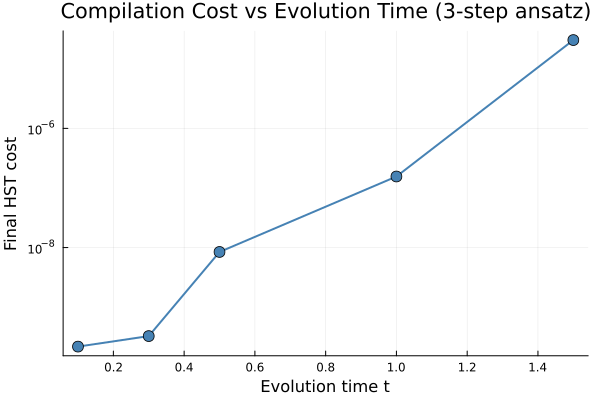

In [9]:
p = plot(time_values, time_costs,
    xlabel="Evolution time t", ylabel="Final HST cost",
    title="Compilation Cost vs Evolution Time ($fixed_steps-step ansatz)",
    marker=:circle, linewidth=2, markersize=6,
    color=:steelblue, legend=false,
    yscale=:log10, size=(600, 400))

p

With Trotter initialization, the cost scaling is clean and monotonic. At short times ($t \ll 1$) the unitary is close to identity and the 3-step ansatz compiles it to $\sim 10^{-10}$. As $t$ grows, the Trotter error between 3-step and 10-step circuits increases, and the optimizer has a harder time closing the gap — the cost at $t = 1.5$ is five orders of magnitude larger than at $t = 0.1$.

## 5. Inspecting the MPO Structure

The bond dimensions of the target MPO reflect the entanglement structure of the unitary. Longer evolution times produce MPOs with larger bond dimensions.

In [10]:
println("MPO bond dimensions at different evolution times:")
for t in [0.1, 0.5, 1.0, 2.0]
    tc = tfim_trotter_circuit(n_qubits, t, h_field; order=:second, n_steps=10)
    mpo = circuit_to_mpo(tc)
    println("  t=$t:  bond dims = $(mpo_bond_dimensions(mpo)),  ",
            "HST vs identity = $(round(hst_cost(mpo, id_mpo), digits=6))")
end

MPO bond dimensions at different evolution times:
  t=0.1:  bond dims = [4, 10, 4],  HST vs identity = 0.067903
  t=0.5:  bond dims = [4, 16, 4],  HST vs identity = 0.86483
  t=1.0:  bond dims = [4, 16, 4],  HST vs identity = 0.999964
  t=2.0:  bond dims = [4, 16, 4],  HST vs identity = 0.930741


## Summary

In this notebook you learned:

- How to represent unitaries as **MPOs** and measure distance via the **HST cost**
- How to use **Trotter circuits as warm-start initialization** for the optimizer, avoiding local minima
- That more Trotter steps (deeper ansatz) monotonically improve the final cost
- How **Trotter order** affects decomposition accuracy: 4th order converges much faster than 1st
- That longer **evolution times** produce harder-to-compile unitaries

**Key functions used:**
- `tfim_trotter_circuit(n, dt, h; order, n_steps)` — Trotter circuit for TFIM
- `circuit_to_mpo(circuit)` — convert circuit to MPO
- `identity_mpo(n)` — identity operator as MPO
- `hst_cost(mpo1, mpo2)` — Hilbert-Schmidt Test distance
- `OptimizerConfig(...)` — optimization parameters
- `optimize!(target, ansatz, config)` — optimize circuit to match target MPO
- `TFIMHamiltonian(unit_cell; J, h)` — TFIM Hamiltonian
- `trotter_error_bound(H, t; order, n_steps)` — Trotter error estimate

**Next**: Notebook 05 provides a detailed comparison of different spin chain Hamiltonians and their Trotter circuits.